In [510]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

In [511]:
CWD = Path(os.getcwd())

log_file = 'workload.log'
flush_stats_file = 'flush_stats.csv'
compaction_stats_file = 'compaction_stats.csv'

FIGSIZE = (8, 6)

plt.style.use('seaborn-v0_8-darkgrid')

In [512]:
def split_by_eq_pull_time(string):
    tmp = string.split(' = ')[1]
    return float(tmp.split(' ')[0])

def get_times(lines):
    """ Get workload exection Time """

    exection_times = {
        'workloadTime': 0,
        'insertsTime': 0,
        'queriesTime': 0,
        'updatesTime': 0,
        'deletesTime': 0,
        'rangeQueriesTime': 0
    }

    for line in lines:
        if line.startswith('Total time taken by workload'):
            exection_times['workloadTime'] = split_by_eq_pull_time(line)
        if line.startswith('Total time taken by inserts'):
            exection_times['insertsTime'] = split_by_eq_pull_time(line)
        if line.startswith('Total time taken by queries'):
            exection_times['queriesTime'] = split_by_eq_pull_time(line)
        if line.startswith('Total time taken by updates'):
            exection_times['updatesTime'] = split_by_eq_pull_time(line)
        if line.startswith('Total time taken by deletes'):
            exection_times['deletesTime'] = split_by_eq_pull_time(line)
        if line.startswith('Total time taken by range queries'):
            exection_times['rangeQueriesTime'] = split_by_eq_pull_time(line)

    return exection_times

def get_flush_stats(df):
    """ Get flush stats in term of total number of flushes, avg data size, avg number of entries """

    flush_stats = {
        'timePoints': df['TimePoint'],
        'totalFlushes': df.shape[0] - 1,
        'avgDataSize': df['DataSize'][:-1].mean(),
        'avgNumEntries': df['NumEntries'][:-1].mean(),
        'lastFlushEntries': df['NumEntries'].iloc[-1],
    }

    return flush_stats

### Pull all the results

In [513]:
all_directories = os.listdir()
all_stats = list()

for dirpath in all_directories:
    if not os.path.isdir(dirpath):
        continue

    prefix_len = 0
    bucket_count = 1

    if 'bucket_count' not in dirpath:
        _, inserts, _, updates, _, range_queries, _, selectivity, _, point_queries, _, memtable, _, entry_size, _, epp, _, buffer_size_in_pages, _, size_ratio = dirpath.split(' ')
    else:
        _, inserts, _, updates, _, range_queries, _, selectivity, _, point_queries, _, memtable, _, entry_size, _, epp, _, buffer_size_in_pages, _, size_ratio, _, prefix_len, _, bucket_count = dirpath.split(' ')

    # print(f"Processing {dirpath}")

    exp = {
        'inserts': int(inserts),
        'updates': int(updates),
        'rangeQueries': int(range_queries),
        'selectivity': float(selectivity),
        'pointQueries': int(point_queries),
        'memtable': memtable.capitalize(),
        'entrySize': int(entry_size),
        'entriesPerPage': int(epp),
        'bufferSizeInPages': int(buffer_size_in_pages),
        'pageSize': int(entry_size) * int(epp),
        'bufferSize': int(entry_size) * int(epp) * int(buffer_size_in_pages),
        'sizeRatio': int(size_ratio),
        'prefixLen': int(prefix_len),
        'bucketCount': int(bucket_count)
    }

    logfilepath = Path(dirpath) / log_file
    time_stats = dict()

    with open(logfilepath, 'r') as f:
        lines = f.readlines()
        time_stats = get_times(lines)
    
    exp.update(time_stats)

    flushfilepath = Path(dirpath) / flush_stats_file
    compactionfilepath = Path(dirpath) / compaction_stats_file

    if flushfilepath.exists():
        flush_stats = pd.read_csv(flushfilepath)
        flush_stats = get_flush_stats(flush_stats)
        exp.update(flush_stats)
    else:
        exp.update({
            'timePoints': 0,
            'totalFlushes': 0,
            'avgDataSize': 0,
            'avgNumEntries': 0
        })
    
    all_stats.append(exp)
        

### Create a DataFrame

In [514]:
df = pd.DataFrame(all_stats)

### Compare all the Memtables for same buffer size keeping prefix_length as 0 and bucket count as 1 (for Hash Skip List and Hash Link List)

In [515]:
def autolabel(rectangle_group, ax):
    for rect in rectangle_group:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                xy = (rect.get_x() + rect.get_width() / 2, height),
                ha='center', color = 'grey', rotation=90, xytext=(0,5), textcoords="offset points")


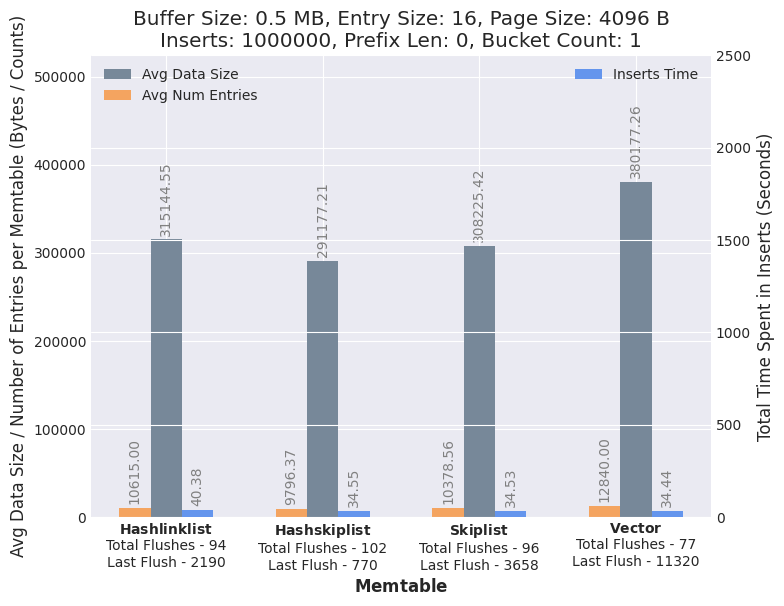

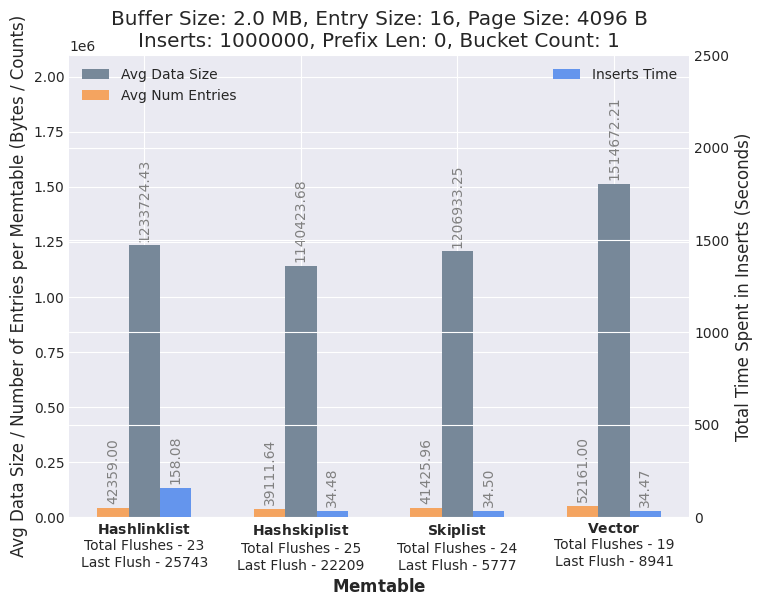

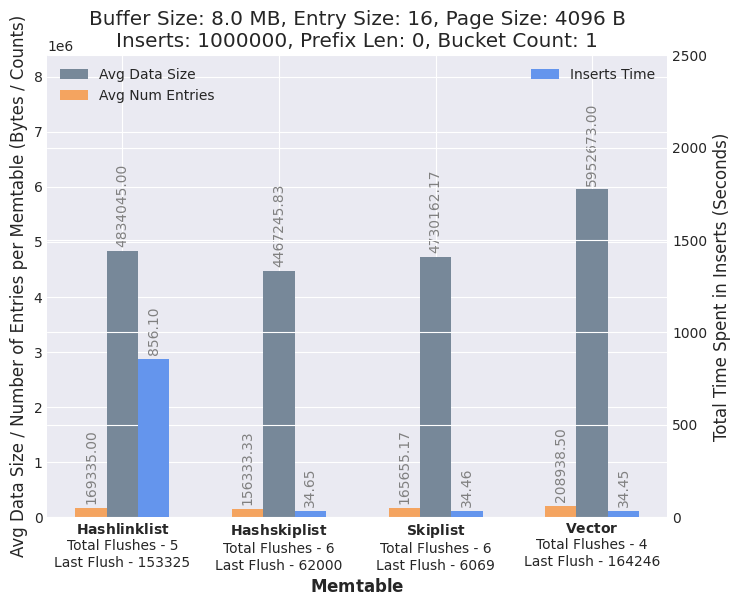

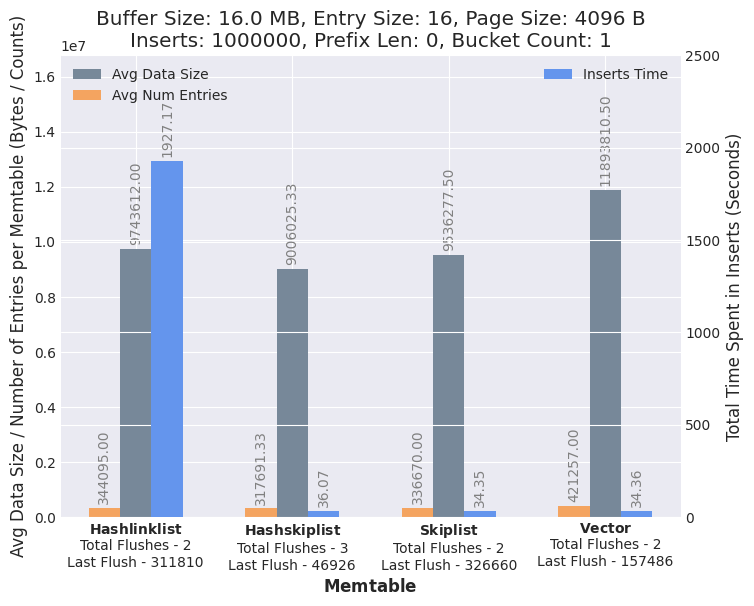

In [516]:
plot_for = [
    {
        "inserts": 1000000,
        "updates": 0,
        "rangeQueries": 0,
        "selectivity": 0,
        "pointQueries": 0,
        "prefixLen": 0,
        "bucketCount": 1,
        "entrySize": 16,
        "pageSize": 4096,
    }
]

buffer_size_in_pages = [128, 512, 2048, 4096]

for exp in plot_for:
    for bsip in buffer_size_in_pages:
        data = df[
            (df["bufferSizeInPages"] == bsip)
            & (df["inserts"] == exp["inserts"])
            & (df["updates"] == exp["updates"])
            & (df["rangeQueries"] == exp["rangeQueries"])
            & (df["selectivity"] == exp["selectivity"])
            & (df["pointQueries"] == exp["pointQueries"])
            & (df["prefixLen"] == exp["prefixLen"])
            & (df["bucketCount"] == exp["bucketCount"])
            & (df["entrySize"] == exp["entrySize"])
            & (df["pageSize"] == exp["pageSize"])
        ]

        data = data.sort_values(by='memtable')

        fig, ax = plt.subplots(figsize=FIGSIZE)
        ax2 = ax.twinx()

        width = 0.2
        x_avg_data_size = [x for x in range(data["memtable"].shape[0])]
        x_workload_time = [x + 0.2 for x in range(data["memtable"].shape[0])]
        x_avg_entries = [x - 0.2 for x in range(data["memtable"].shape[0])]

        rect1 = ax.bar(x_avg_data_size, data['avgDataSize'], width, label='Avg Data Size', color='lightslategray')
        rect2 = ax.bar(x_avg_entries, data['avgNumEntries'], width, label='Avg Num Entries', color='sandybrown')
        rect3 = ax2.bar(x_workload_time, data['insertsTime'], width, label='Inserts Time', color='cornflowerblue')

        ax.set_xlabel('$\mathbf{Memtable}$')
        ax.set_ylabel('Avg Data Size / Number of Entries per Memtable (Bytes / Counts)')
        ax2.set_ylabel('Total Time Spent in Inserts (Seconds)')

        autolabel(rect1, ax)
        autolabel(rect2, ax)
        autolabel(rect3, ax2)

        ax.set_xticks([x for x in range(data["memtable"].shape[0])])
        ax.set_xticklabels([f"$\mathbf{{{row['memtable']}}}$\nTotal Flushes - {row['totalFlushes']}\nLast Flush - {row['lastFlushEntries']}" for _, row in data.iterrows()])

        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')

        ax.set_ylim(0, bsip * 4096)
        ax2.set_ylim(0, 2500)

        plt.title(f'Buffer Size: {((bsip * 4096) / 1024)/1024} MB, Entry Size: {exp["entrySize"]}, Page Size: {exp["pageSize"]} B\nInserts: {exp["inserts"]}, Prefix Len: {exp["prefixLen"]}, Bucket Count: {exp["bucketCount"]}')
        plt.show()


<br><br><br><br><br><br><br><br><br><br>

### Compare the Time Spent in inserts, time spent for full workload exectuion for same Memtable with different buffer sizes

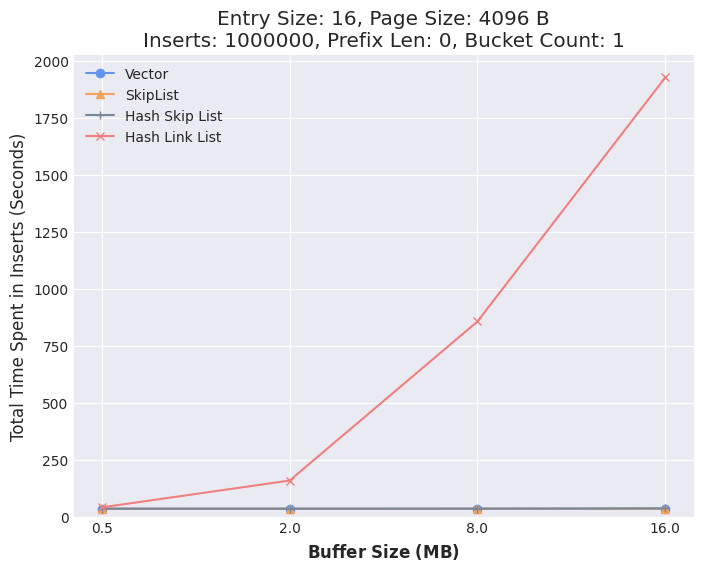

In [517]:
plot_for = [
    {
        "inserts": 1000000,
        "updates": 0,
        "rangeQueries": 0,
        "selectivity": 0,
        "pointQueries": 0,
        "prefixLen": 0,
        "bucketCount": 1,
        "entrySize": 16,
        "pageSize": 4096,
    }
]

buffer_size_in_pages = [128, 512, 2048, 4096]
skip_list_and_vector_group = None

for exp in plot_for:
    data = df[
        (df["inserts"] == exp["inserts"])
        & (df["updates"] == exp["updates"])
        & (df["rangeQueries"] == exp["rangeQueries"])
        & (df["selectivity"] == exp["selectivity"])
        & (df["pointQueries"] == exp["pointQueries"])
        & (df["prefixLen"] == exp["prefixLen"])
        & (df["bucketCount"] == exp["bucketCount"])
        & (df["entrySize"] == exp["entrySize"])
        & (df["pageSize"] == exp["pageSize"])
    ]

    data = data.sort_values(by='bufferSize')

    mem_grouped_df = data.groupby('memtable')
    skip_list_and_vector_group = mem_grouped_df

    fig, ax = plt.subplots(figsize=FIGSIZE)
    xticks = [x for x in range(mem_grouped_df.get_group('Vector')['bufferSize'].shape[0])]

    ax.plot(xticks, mem_grouped_df.get_group('Vector')['insertsTime'], label='Vector', color='cornflowerblue', marker='o')
    ax.plot(xticks, mem_grouped_df.get_group('Skiplist')['insertsTime'], label='SkipList', color='sandybrown', marker='^')
    ax.plot(xticks, mem_grouped_df.get_group('Hashskiplist')['insertsTime'], label='Hash Skip List', color='lightslategray', marker='+')
    ax.plot(xticks, mem_grouped_df.get_group('Hashlinklist')['insertsTime'], label='Hash Link List', color='lightcoral', marker='x')

    ax.set_xlabel('$\mathbf{{Buffer\ Size\ (MB)}}$')
    ax.set_ylabel('Total Time Spent in Inserts (Seconds)')

    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{((k)/1024)/1024}" for k in mem_grouped_df.get_group('Vector')['bufferSize']])

    ax.legend(loc='upper left')
    # ax2.legend(loc='upper right')

    ax.set_ylim(0, max(data['insertsTime']) + 100)

    plt.title(f'Entry Size: {exp["entrySize"]}, Page Size: {exp["pageSize"]} B\nInserts: {exp["inserts"]}, Prefix Len: {exp["prefixLen"]}, Bucket Count: {exp["bucketCount"]}')
    plt.show()


<br><br><br><br><br><br><br><br><br><br>


### Compare the Time Spent in inserts, time spent for full workload exectuion for same Memtable with different prefix lengths and bucket counts

prefix_lengths = [0, 2, 6, 10, 12]
bucket_counts = [1, 100, 10000]

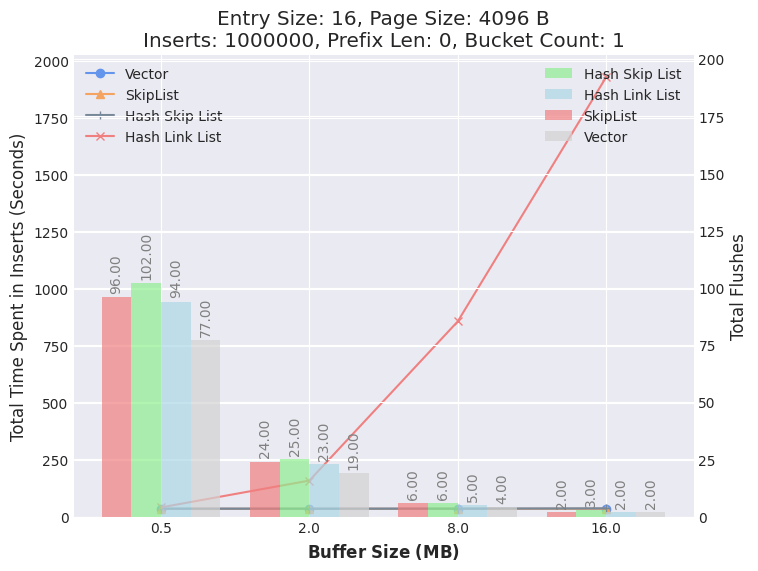

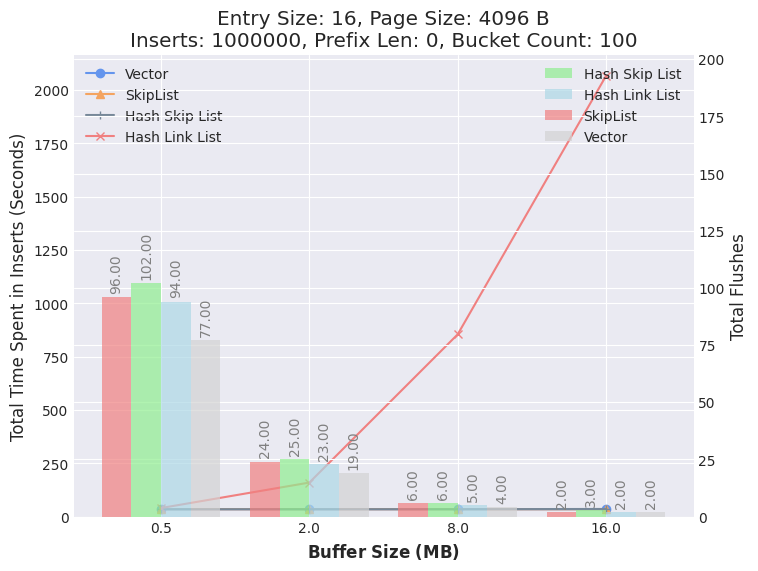

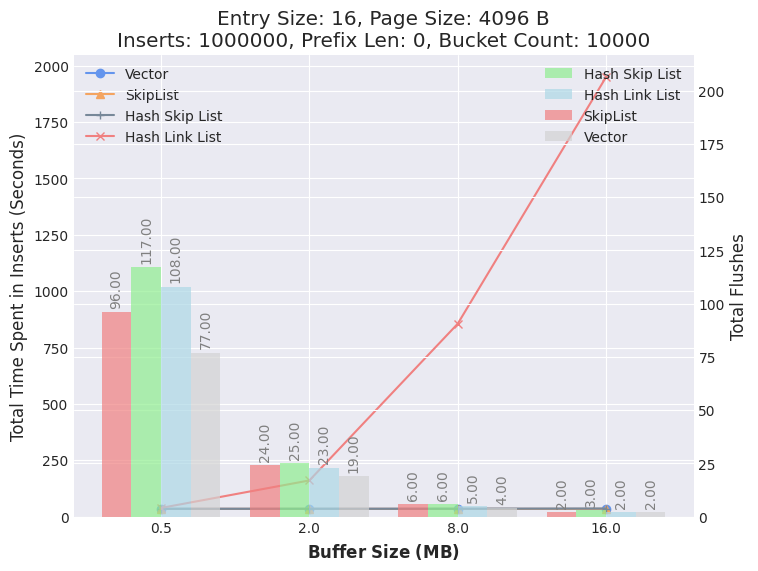

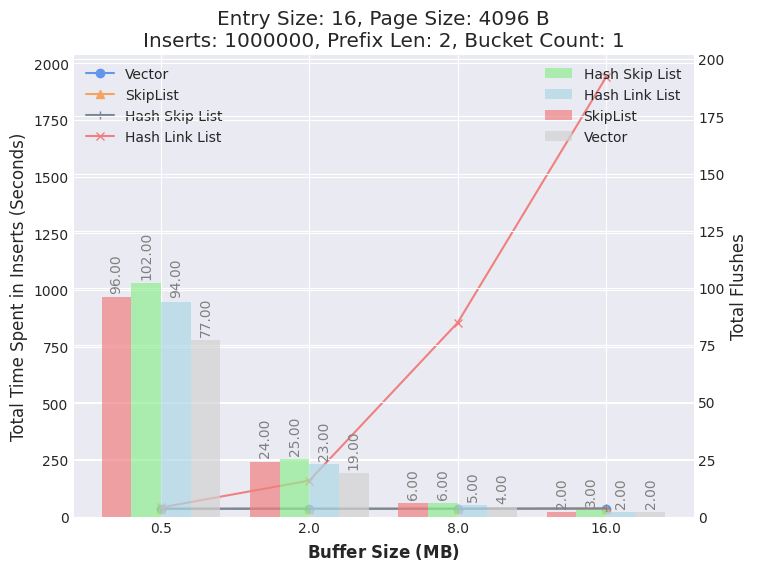

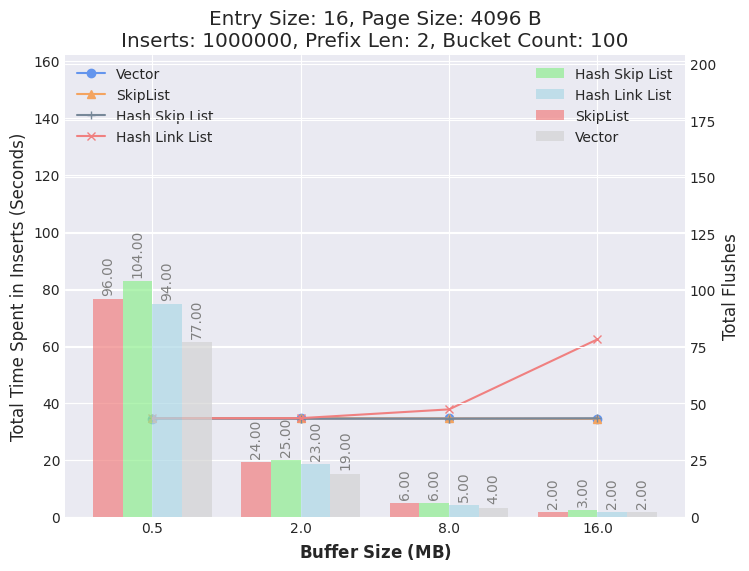

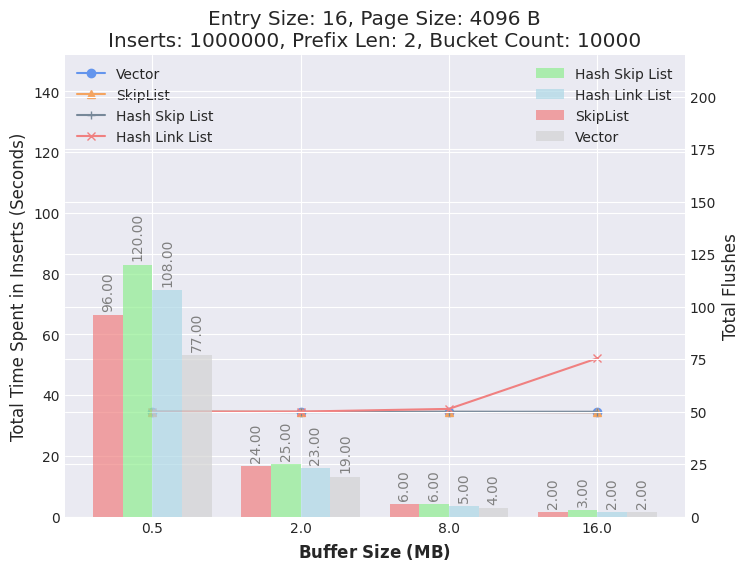

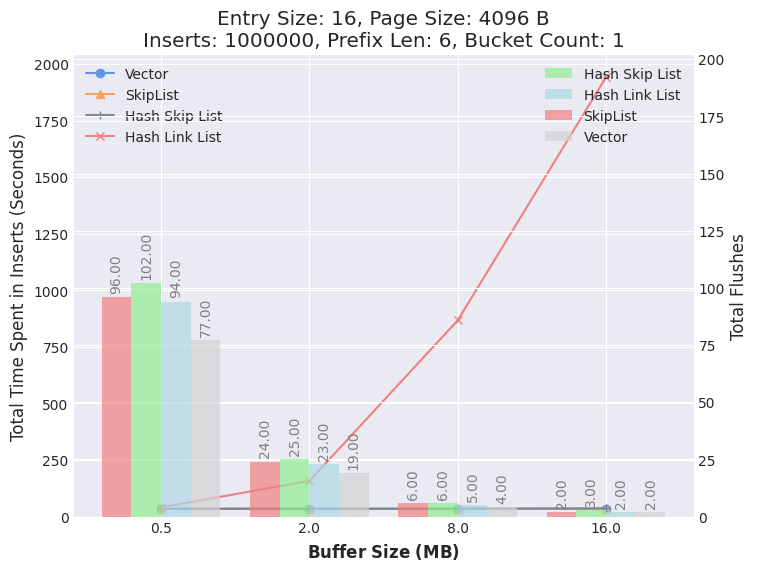

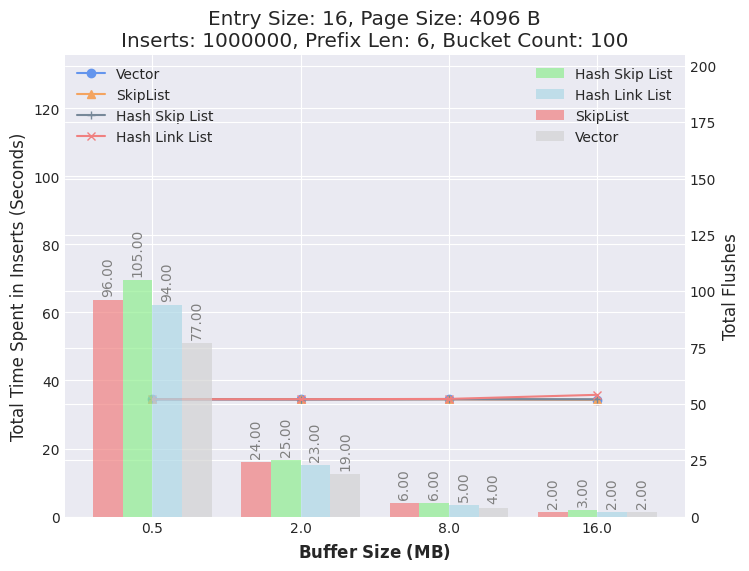

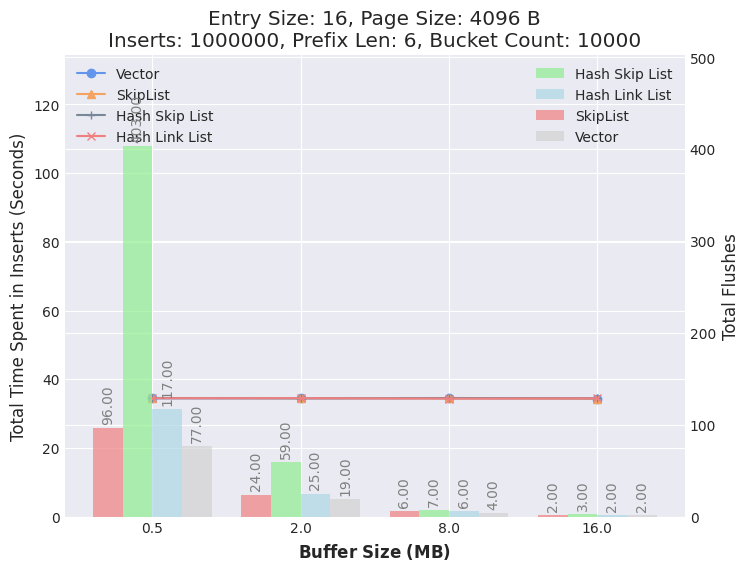

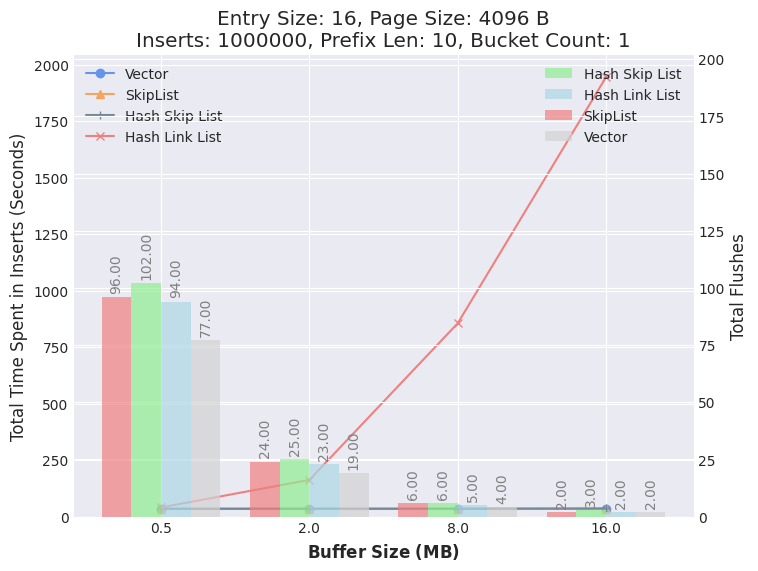

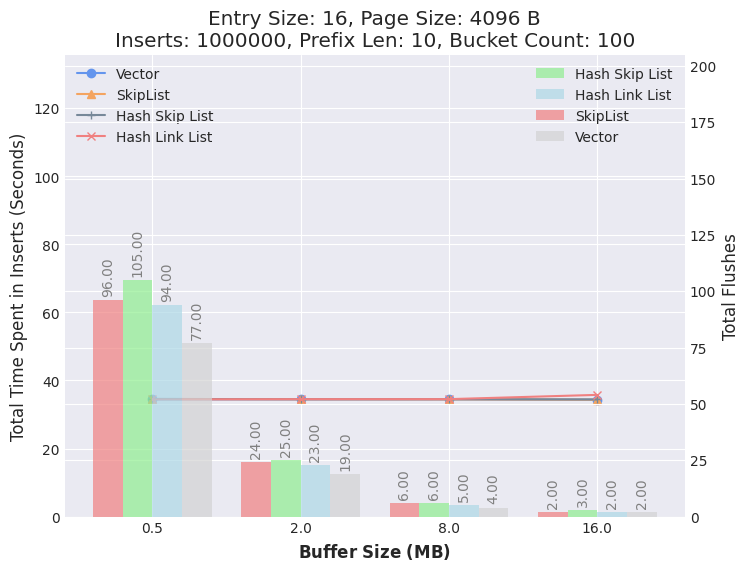

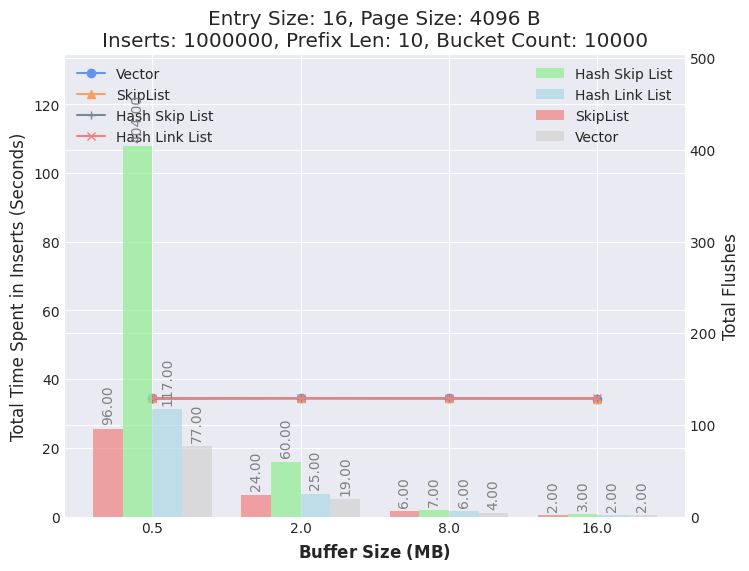

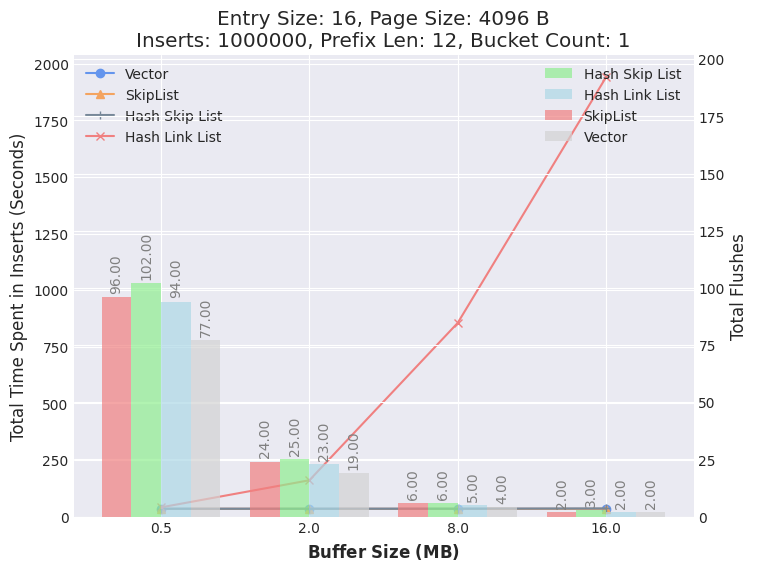

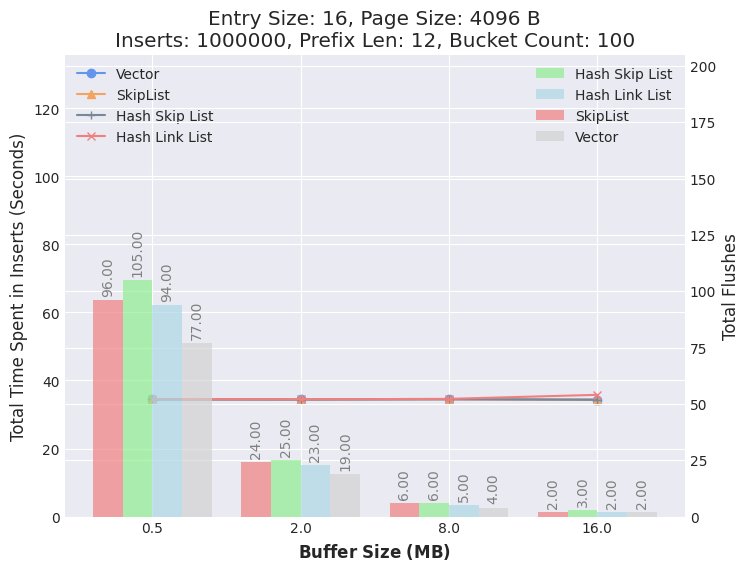

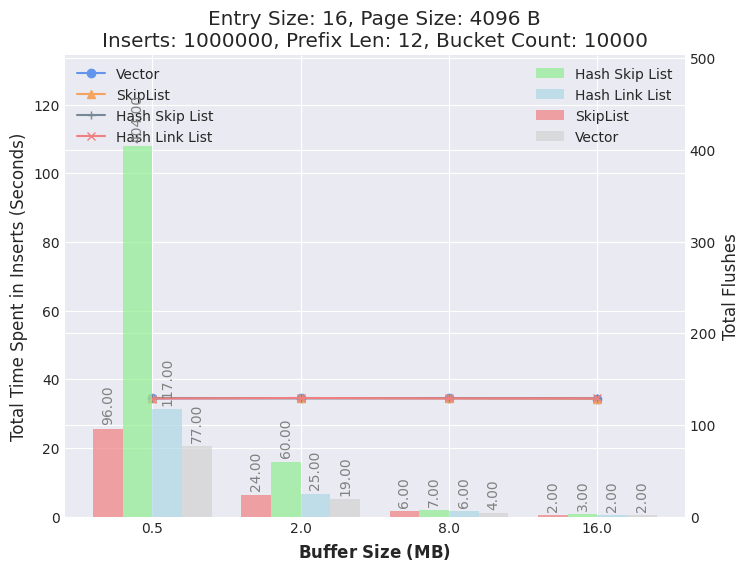

In [520]:
plot_for = [
    # {
    #     "inserts": 1000000,
    #     "updates": 0,
    #     "rangeQueries": 0,
    #     "selectivity": 0,
    #     "pointQueries": 0,
    #     "prefixLen": 0,
    #     "bucketCount": 1,
    #     "entrySize": 16,
    #     "pageSize": 4096,
    # }
]

prefix_lengths = [0, 2, 6, 10, 12]
bucket_counts = [1, 100, 10000]

for prefix_len in prefix_lengths:
    for bucket_count in bucket_counts:
        plot_for.append(
            {
                "inserts": 1000000,
                "updates": 0,
                "rangeQueries": 0,
                "selectivity": 0,
                "pointQueries": 0,
                "prefixLen": prefix_len,
                "bucketCount": bucket_count,
                "entrySize": 16,
                "pageSize": 4096,
            }
        )

buffer_size_in_pages = [128, 512, 2048, 4096]

for exp in plot_for:
    data = df[
        (df["inserts"] == exp["inserts"])
        & (df["updates"] == exp["updates"])
        & (df["rangeQueries"] == exp["rangeQueries"])
        & (df["selectivity"] == exp["selectivity"])
        & (df["pointQueries"] == exp["pointQueries"])
        & (df["prefixLen"] == exp["prefixLen"])
        & (df["bucketCount"] == exp["bucketCount"])
        & (df["entrySize"] == exp["entrySize"])
        & (df["pageSize"] == exp["pageSize"])
    ]
    data2 = df[
        (df["inserts"] == exp["inserts"])
        & (df["updates"] == exp["updates"])
        & (df["rangeQueries"] == exp["rangeQueries"])
        & (df["selectivity"] == exp["selectivity"])
        & (df["pointQueries"] == exp["pointQueries"])
        & (df["prefixLen"] == 0)
        & (df["bucketCount"] == 1)
        & (df["entrySize"] == exp["entrySize"])
        & (df["pageSize"] == exp["pageSize"])
    ]

    data = data.sort_values(by="bufferSize")
    data2 = data2.sort_values(by="bufferSize")

    mem_grouped_df = data.groupby("memtable")
    skip_list_and_vector_group = data2.groupby("memtable")

    fig, ax = plt.subplots(figsize=FIGSIZE)

    ax2 = ax.twinx()

    xticks = [
        x
        for x in range(mem_grouped_df.get_group("Hashskiplist")["bufferSize"].shape[0])
    ]

    hash_skip_list_pos = [
        x - 0.1
        for x in range(mem_grouped_df.get_group("Hashskiplist")["bufferSize"].shape[0])
    ]
    hash_link_list_pos = [
        x + 0.1
        for x in range(mem_grouped_df.get_group("Hashlinklist")["bufferSize"].shape[0])
    ]
    skip_list_pos = [
        x - 0.3
        for x in range(
            skip_list_and_vector_group.get_group("Skiplist")["bufferSize"].shape[0]
        )
    ]
    vector_pos = [
        x + 0.3
        for x in range(
            skip_list_and_vector_group.get_group("Vector")["bufferSize"].shape[0]
        )
    ]

    ax.plot(
        xticks,
        skip_list_and_vector_group.get_group("Vector")["insertsTime"],
        label="Vector",
        color="cornflowerblue",
        marker="o",
    )
    ax.plot(
        xticks,
        skip_list_and_vector_group.get_group("Skiplist")["insertsTime"],
        label="SkipList",
        color="sandybrown",
        marker="^",
    )
    ax.plot(
        xticks,
        mem_grouped_df.get_group("Hashskiplist")["insertsTime"],
        label="Hash Skip List",
        color="lightslategray",
        marker="+",
    )
    ax.plot(
        xticks,
        mem_grouped_df.get_group("Hashlinklist")["insertsTime"],
        label="Hash Link List",
        color="lightcoral",
        marker="x",
    )
    r1 = ax2.bar(
        hash_skip_list_pos,
        mem_grouped_df.get_group("Hashskiplist")["totalFlushes"],
        label="Hash Skip List",
        color="lightgreen",
        alpha=0.7,
        width=0.2,
    )
    r2 = ax2.bar(
        hash_link_list_pos,
        mem_grouped_df.get_group("Hashlinklist")["totalFlushes"],
        label="Hash Link List",
        color="lightblue",
        alpha=0.7,
        width=0.2,
    )
    r3 = ax2.bar(
        skip_list_pos,
        skip_list_and_vector_group.get_group("Skiplist")["totalFlushes"],
        label="SkipList",
        color="lightcoral",
        alpha=0.7,
        width=0.2,
    )
    r4 = ax2.bar(
        vector_pos,
        skip_list_and_vector_group.get_group("Vector")["totalFlushes"],
        label="Vector",
        color="lightgray",
        alpha=0.7,
        width=0.2,
    )

    ax.set_xlabel("$\mathbf{{Buffer\ Size\ (MB)}}$")
    ax.set_ylabel("Total Time Spent in Inserts (Seconds)")
    ax2.set_ylabel("Total Flushes")

    ax.set_xticks(xticks)
    ax.set_xticklabels(
        [
            f"{((k)/1024)/1024}"
            for k in mem_grouped_df.get_group("Hashskiplist")["bufferSize"]
        ]
    )

    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")

    autolabel(r1, ax2)
    autolabel(r2, ax2)
    autolabel(r3, ax2)
    autolabel(r4, ax2)

    ax.set_ylim(0, max(data["insertsTime"]) + 100)
    ax2.set_ylim(0, max(data["totalFlushes"]) + 100)

    plt.title(
        f'Entry Size: {exp["entrySize"]}, Page Size: {exp["pageSize"]} B\nInserts: {exp["inserts"]}, Prefix Len: {exp["prefixLen"]}, Bucket Count: {exp["bucketCount"]}'
    )
    plt.show()

<br><br><br><br><br><br><br><br><br><br>

### Shows the patterns of time spent in inserts when prefix length changes with bucket count for same Memtable and buffer size

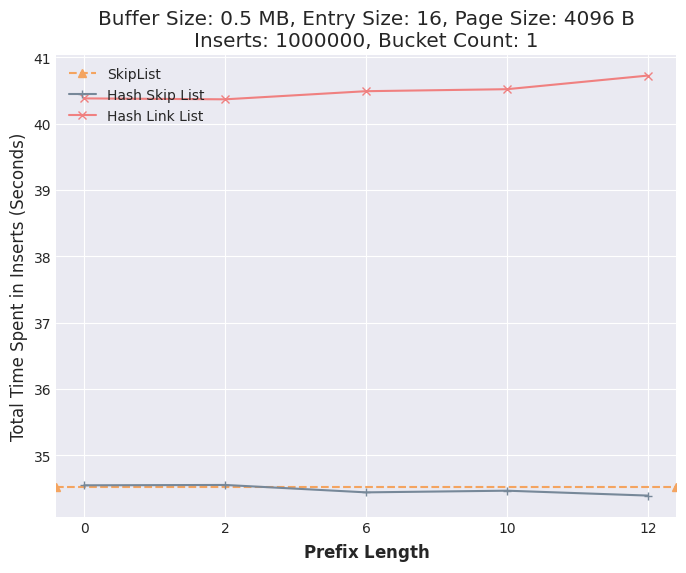

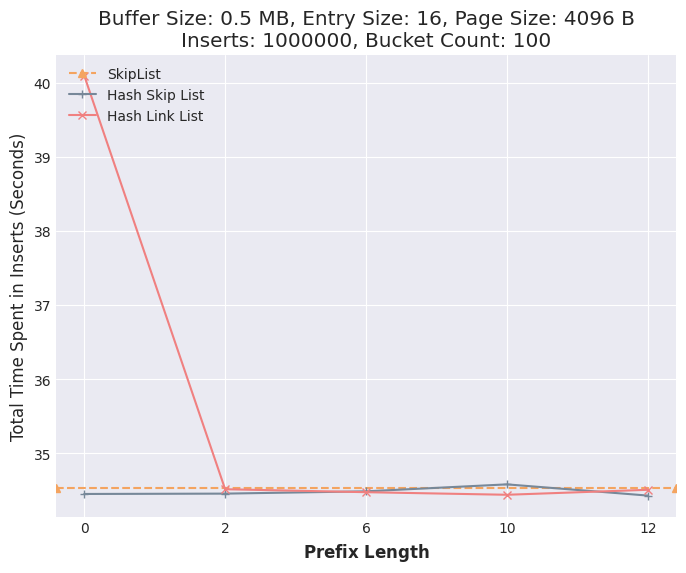

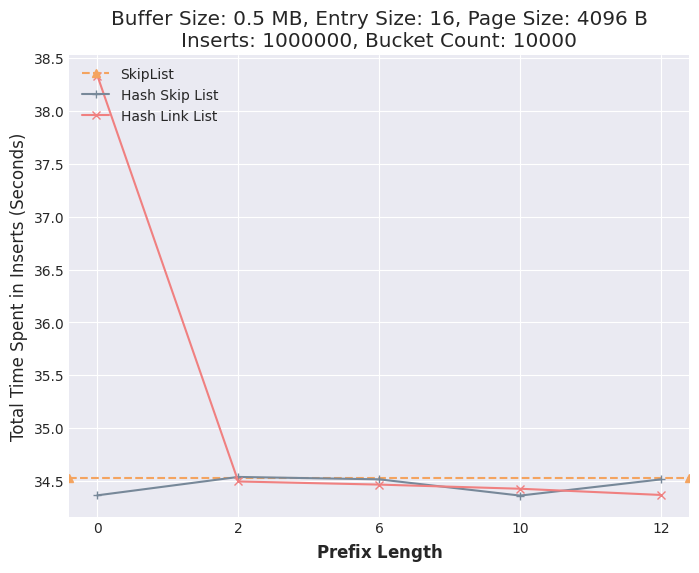

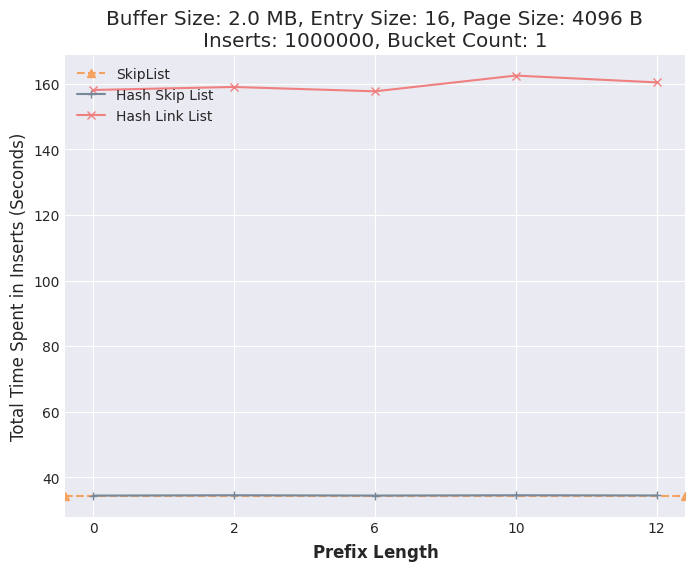

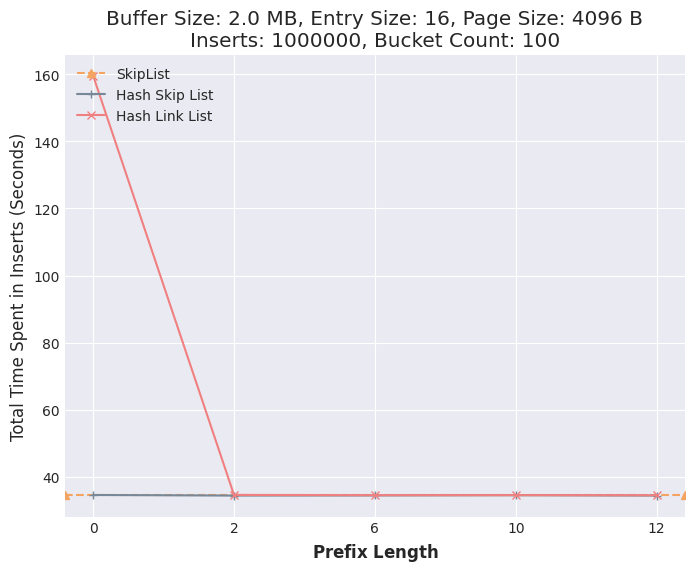

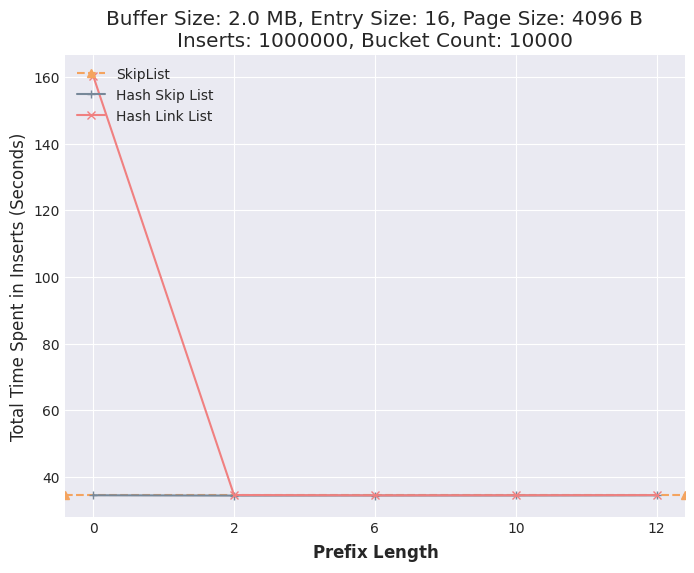

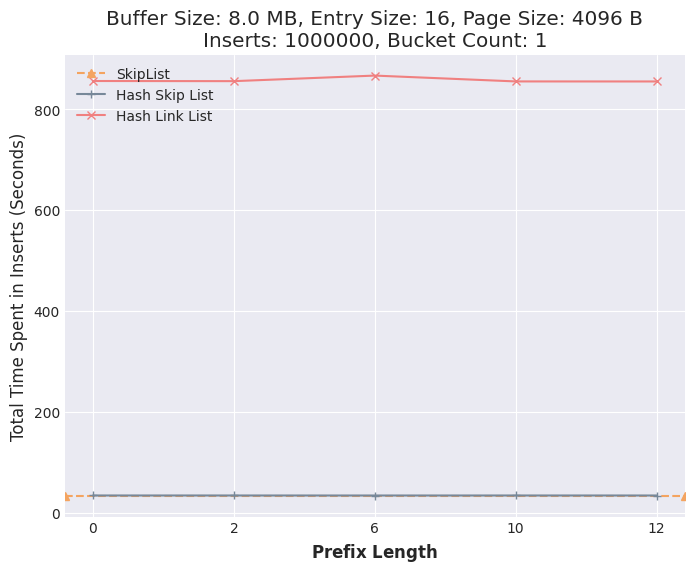

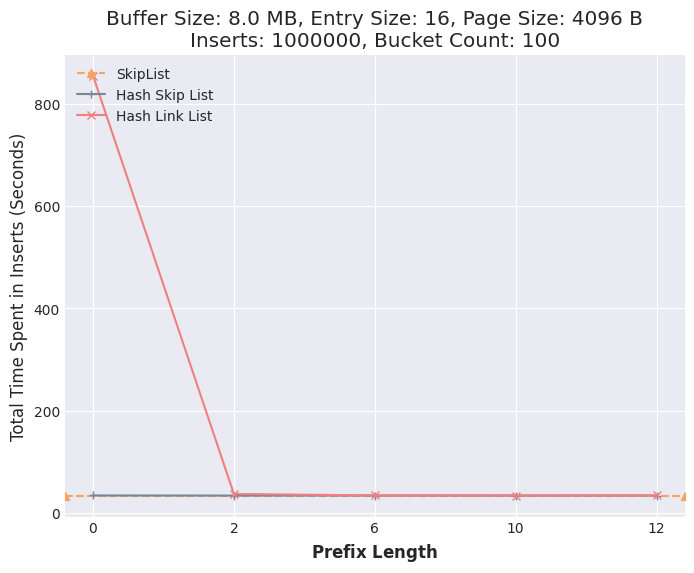

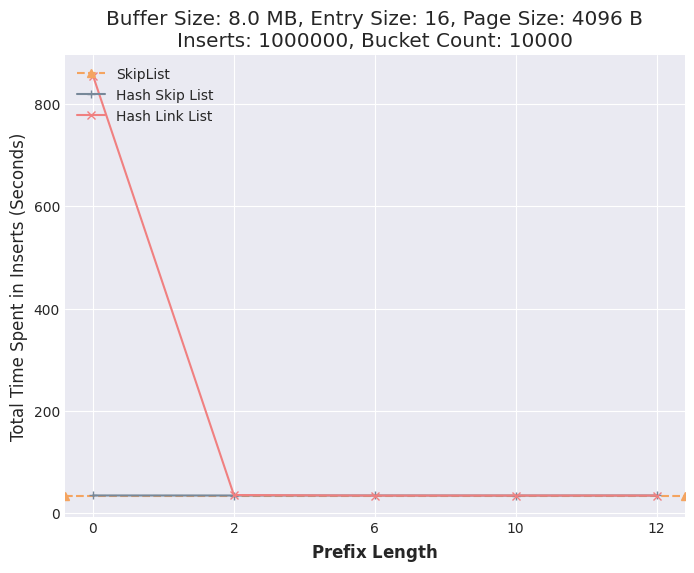

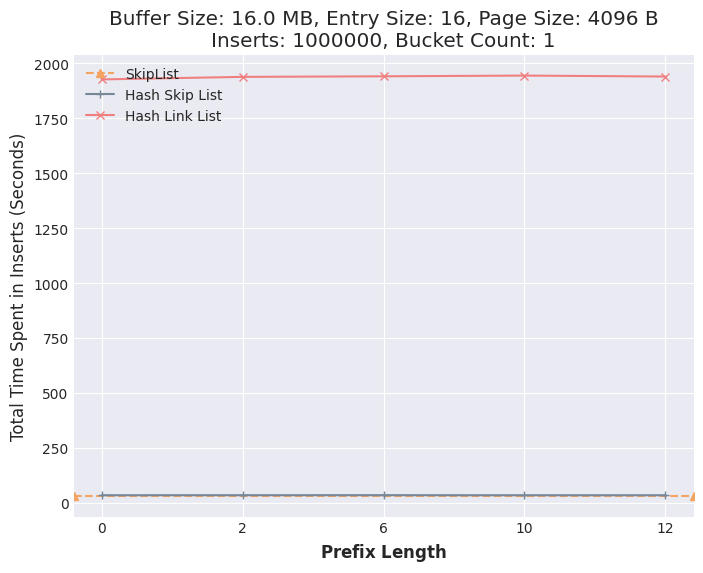

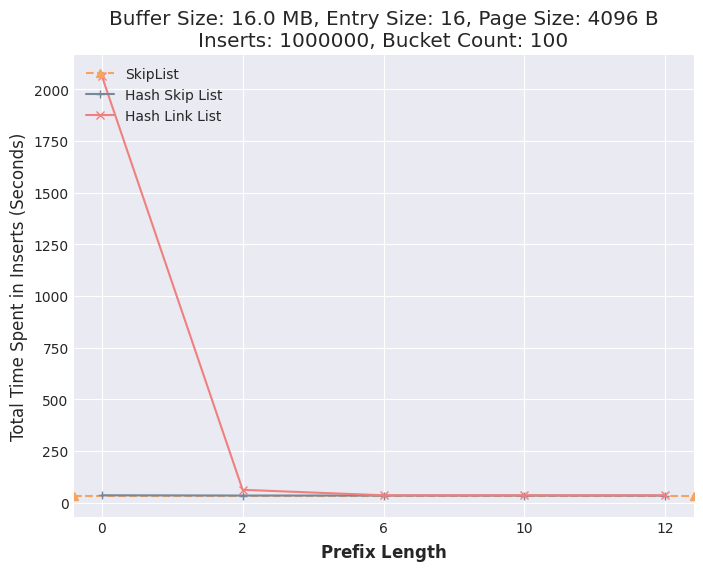

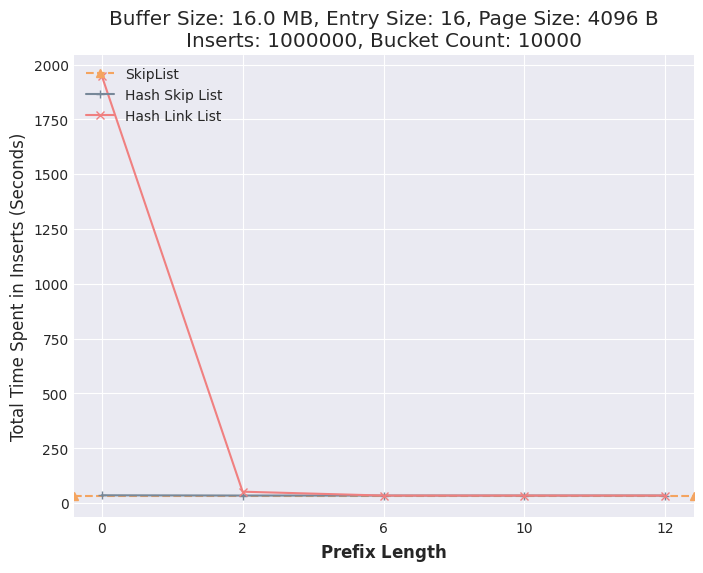

In [549]:
plot_for = [
    # {
    #     "inserts": 1000000,
    #     "updates": 0,
    #     "rangeQueries": 0,
    #     "selectivity": 0,
    #     "pointQueries": 0,
    #     "prefixLen": 0,
    #     "bucketCount": 1,
    #     "entrySize": 16,
    #     "pageSize": 4096,
    # }
]

buffer_size_in_pages = [128, 512, 2048, 4096]
prefix_lengths = [0, 2, 6, 10, 12]
bucket_counts = [1, 100, 10000]

for buffer_size in buffer_size_in_pages:
    for bucket_count in bucket_counts:
        plot_for.append(
            {
                "inserts": 1000000,
                "updates": 0,
                "rangeQueries": 0,
                "selectivity": 0,
                "pointQueries": 0,
                "bucketCount": bucket_count,
                "entrySize": 16,
                "pageSize": 4096,
                "bufferSizeInPages": buffer_size,
            }
        )


for exp in plot_for:
    data = df[
        (df["inserts"] == exp["inserts"])
        & (df["updates"] == exp["updates"])
        & (df["rangeQueries"] == exp["rangeQueries"])
        & (df["selectivity"] == exp["selectivity"])
        & (df["pointQueries"] == exp["pointQueries"])
        & (df["bucketCount"] == exp["bucketCount"])
        & (df["entrySize"] == exp["entrySize"])
        & (df["pageSize"] == exp["pageSize"])
        & (df["bufferSizeInPages"] == exp["bufferSizeInPages"])
    ]

    data = data.sort_values(by="prefixLen")

    mem_grouped_df = data.groupby("memtable")

    fig, ax = plt.subplots(figsize=FIGSIZE)

    # ax2 = ax.twinx()

    xticks = [
        x
        for x in range(mem_grouped_df.get_group("Hashskiplist")["prefixLen"].shape[0])
    ]

    # hash_skip_list_pos = [
    #     x - 0.1
    #     for x in range(mem_grouped_df.get_group("Hashskiplist")["prefixLen"].shape[0])
    # ]
    # hash_link_list_pos = [
    #     x + 0.1
    #     for x in range(mem_grouped_df.get_group("Hashlinklist")["prefixLen"].shape[0])
    # ]
    # skip_list_pos = [
    #     x - 0.3
    #     for x in range(
    #         skip_list_and_vector_group.get_group("Skiplist")["prefixLen"].shape[0]
    #     )
    # ]
    # vector_pos = [
    #     x + 0.3
    #     for x in range(
    #         skip_list_and_vector_group.get_group("Vector")["prefixLen"].shape[0]
    #     )
    # ]

    ax.axhline(
        # xticks,
        y=skip_list_and_vector_group.get_group("Vector").where(skip_list_and_vector_group.get_group("Vector")["bufferSizeInPages"] == exp["bufferSizeInPages"]).dropna()['insertsTime'].values[0],
        # skip_list_and_vector_group.get_group("Vector")["insertsTime"],
        label="Vector",
        color="cornflowerblue",
        linestyle="--",
        marker="o",
    )
    ax.axhline(
        # xticks,
        y=skip_list_and_vector_group.get_group("Skiplist").where(skip_list_and_vector_group.get_group("Skiplist")["bufferSizeInPages"] == exp["bufferSizeInPages"]).dropna()['insertsTime'].values[0],
        label="SkipList",
        color="sandybrown",
        linestyle="--",
        marker="^",
    )
    ax.plot(
        xticks,
        mem_grouped_df.get_group("Hashskiplist")["insertsTime"],
        label="Hash Skip List",
        color="lightslategray",
        marker="+",
    )
    ax.plot(
        xticks,
        mem_grouped_df.get_group("Hashlinklist")["insertsTime"],
        label="Hash Link List",
        color="lightcoral",
        marker="x",
    )





    # r1 = ax2.bar(
    #     hash_skip_list_pos,
    #     mem_grouped_df.get_group("Hashskiplist")["totalFlushes"],
    #     label="Hash Skip List",
    #     color="lightgreen",
    #     alpha=0.5,
    #     width=0.2,
    # )
    # r2 = ax2.bar(
    #     hash_link_list_pos,
    #     mem_grouped_df.get_group("Hashlinklist")["totalFlushes"],
    #     label="Hash Link List",
    #     color="lightblue",
    #     alpha=0.5,
    #     width=0.2,
    # )
    # r3 = ax2.bar(
    #     skip_list_pos,
    #     skip_list_and_vector_group.get_group("Skiplist")["totalFlushes"],
    #     label="SkipList",
    #     color="lightcoral",
    #     alpha=0.5,
    #     width=0.2,
    # )
    # r4 = ax2.bar(
    #     vector_pos,
    #     skip_list_and_vector_group.get_group("Vector")["totalFlushes"],
    #     label="Vector",
    #     color="lightgray",
    #     alpha=0.5,
    #     width=0.2,
    # )

    ax.set_xlabel("$\mathbf{{Prefix\ Length}}$")
    ax.set_ylabel("Total Time Spent in Inserts (Seconds)")
    # ax2.set_ylabel("Total Flushes")

    ax.set_xticks(xticks)
    ax.set_xticklabels(
        [
            f"{k}"
            for k in mem_grouped_df.get_group("Hashskiplist")["prefixLen"]
        ]
    )

    ax.legend(loc="upper left")
    # ax2.legend(loc="upper right")

    # autolabel(r1, ax2)
    # autolabel(r2, ax2)
    # autolabel(r3, ax2)
    # autolabel(r4, ax2)

    # ax.set_ylim(0, max(data["insertsTime"]) + 100)
    # ax2.set_ylim(0, max(data["totalFlushes"]) + 100)

    plt.title(
        f'Buffer Size: {((exp["bufferSizeInPages"]*4096)/1024)/1024} MB, Entry Size: {exp["entrySize"]}, Page Size: {exp["pageSize"]} B\nInserts: {exp["inserts"]}, Bucket Count: {exp["bucketCount"]}'
    )
    plt.show()